In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Locating schools with a shortage of applicants

## Objective

Here is a quote from Max Brawer, researcher who works along with PASSNYC:

> "Only a third (roughly) of eligible students take the SHSAT, and our goal is to drive more test takers (you can't get in if you don't sit for the test!)."

It briefly summarizes main objective of PASSNYC, that is, bringing new students into taking SHSAT.

But, where should PASSNYC put its efforts? In this notebook I make recommendations about this, indicating schools where the actual amount of SHSAT test takers was far below what would be from its students.

## Method

First, I create a model that predicts the percentage of SHSAT applicants of a school, given its distribution of grades on the New York State tests.

Based on this model, I estimate what would be expected for each school and calculate the difference between the actual number of applicants and the expected number of applicants. This difference is a good indicator of the gap between potential applicants in a school and actual applicants.

## Model

The percentage of SHSAT takers of each school is estimated using a robust logit regression. Only schools with a known outcome are used to fit the model.

Inputs are preprocessed using PCA (Principal Component Analysis). I do so to remove redundancy from the model.

## Data

The data used here follows a group of students that took the NYS tests and SHSAT in 2017.

Sources:
- https://infohub.nyced.org/reports-and-policies/citywide-information-and-data/test-results
- https://data.cityofnewyork.us/Education/2017-2018-SHSAT-Admissions-Test-Offers-By-Sending-/vsgi-eeb5/

## Results

This model is good, but not perfect. I intend to do additional work to improve it, all the while trying to provide more explanation of what is being done.

For a pretty well written kernel that uses the same principle as this, check [Diamonds in the Rough with Machine Learning][1].

[1]: https://www.kaggle.com/bensolucky/diamonds-in-the-rough-with-machine-learning

# Prepare the data

In [2]:
# load
df = pd.read_pickle('../data/process/schools2017.pkl')

# select columns
df = df[[        
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    
    '# Students in HS Admissions',
    '# SHSAT Testers',
    '% SHSAT Testers',
]].copy()
print(df.shape[0], "schools")

# drop schools with missing test data
df = df[df.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]
print(df.shape[0], "schools after dropping missing test data")

# schools with 0-5 SHSAT testers have this value set to NaN
applicantsok = df['# SHSAT Testers'].notnull()

# convert percentages to the (0, 1) range
bad_pct_c = [
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]
df.loc[:, bad_pct_c] = df.loc[:, bad_pct_c] / 100.0

# standardize score columns (algorithm stability)
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']
df.loc[:, score_c] = scale(df.loc[:, score_c])

594 schools
588 schools after dropping missing test data


# Create the model

We will use a robust linear regression over the logits.

- A robust regression improves the detection of outliers.<sup> 1</sup>
- Output probabilities are transformed to logits, making the model a [logit regression][1].

<sub>1: The objective of the analysis is not exactly outlier detection, but could be expressed as so: we want to find schools whose rates of applicants are *far away* from what would be expected given their students scores.</sub>
    
[1]: https://en.wikipedia.org/wiki/Logistic_regression

## Transform the inputs

In [3]:
base_df = df[[  # explanatory variables
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

n_components = 4  # from local cross-validation
pca = PCA(n_components)
transformed = pca.fit_transform(base_df)
transformed = pd.DataFrame(transformed, index=base_df.index, columns=["PC{}".format(i+1) for i in range(n_components)])
transformed.head()

inputs = transformed
inputs.insert(0, 'Constant', 1.0)

## Fit/Predict

In [4]:
#data
inputs_fit = inputs[applicantsok]
outputs_fit = logit(df['% SHSAT Testers'][applicantsok])
inputs_predict = inputs

# fit
model = sm.RLM(outputs_fit, inputs_fit, M=sm.robust.norms.HuberT())
results = model.fit()

# predict
predictions = model.predict(results.params, exog=inputs_predict)
predictions = pd.Series(predictions, index=inputs_predict.index)
predictions.name = 'Predictions'

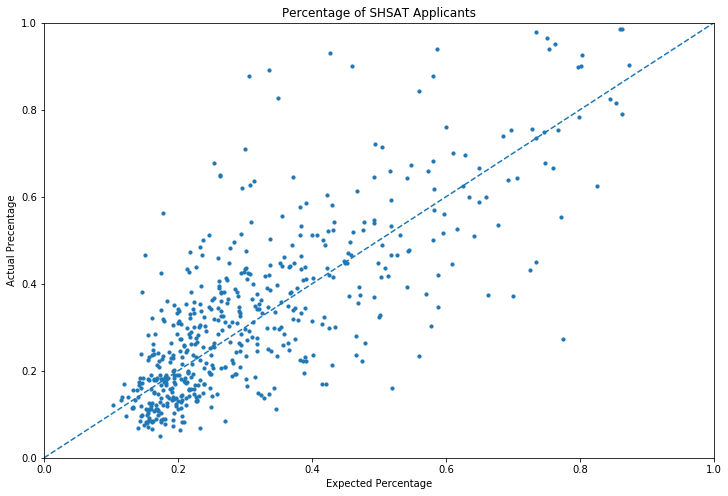

In [5]:
xs = expit(predictions[applicantsok])  # expit function is the inverse of the logit
ys = expit(outputs_fit)

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, s=10)
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Percentage of SHSAT Applicants")
plt.xlabel("Expected Percentage")
plt.ylabel("Actual Precentage");

# Arrange results

Here I arrange the results into a table that I believe is gonna be useful for PASSNYC.

Instead of keeping track of minimum and max values, I will just assume that exactly 5 students take the SHSAT in schools with missing information.

In [6]:
def from_counts(shsat_counts, hs_counts):
    return pd.DataFrame({
        'logit': logit(shsat_counts / hs_counts),
        'pct': shsat_counts / hs_counts,
        'cnt': shsat_counts,
    })

def from_logits(shsat_logits, hs_counts):
    return pd.DataFrame({
        'logit': shsat_logits,
        'pct': expit(shsat_logits),
        'cnt': expit(shsat_logits) * hs_counts,
    })

In [7]:
# actual values  ---

# schools with 0 to 5 applicants
hs_counts = df[~applicantsok]['# Students in HS Admissions']
max_v = from_counts(5, hs_counts)

# schools with 6 or more applicants
shsat_counts = df[applicantsok]['# SHSAT Testers']
hs_counts = df[applicantsok]['# Students in HS Admissions']
pontual_v = from_counts(shsat_counts, hs_counts)


# expected values  ---

shsat_logits = predictions
hs_counts = df['# Students in HS Admissions']
expected_v = from_logits(shsat_logits, hs_counts)


# differences  ---

max_diff = (max_v - expected_v).dropna()
pontual_diff = (pontual_v - expected_v).dropna()


# join everything  ---

everything = pd.DataFrame({
    'Actual #': pd.concat([max_v, pontual_v])['cnt'],
    'Estimated #': expected_v['cnt'],
    'Difference #': pd.concat([max_diff, pontual_diff])['cnt'],
            
    'Actual %': pd.concat([max_v, pontual_v])['pct'],
    'Estimated %': expected_v['pct'],
    'Difference %': pd.concat([max_diff, pontual_diff])['pct'],
})
everything['Difference Ratio'] = everything['Difference #'] / everything['Actual #']

everything = everything.sort_index()
everything.head().style. \
    format('{:.0f}', subset=pd.IndexSlice[:, 'Actual #':'Difference #']). \
    format('{:.0%}', subset=pd.IndexSlice[:, 'Actual %':'Difference %']). \
    format('{:.2f}', subset=['Difference Ratio'])

,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Difference Ratio
01M034,6,10,-4,10%,17%,-7%,-0.69
01M140,6,12,-6,9%,18%,-9%,-1.02
01M184,67,53,14,76%,60%,16%,0.21
01M188,5,11,-6,8%,19%,-11%,-1.26
01M301,11,11,0,22%,21%,1%,0.04


This table in itself is a nice deliverable to PASSNYC. It provides an estimate of the gap of applicants in each school, a strong indicator of where resources may be harnessed best.

# Example usage of the table

In [8]:
# load dataframes
# 'vis' are those that are easier to visualize

schools = pd.read_pickle('../data/process/schools2017.pkl')
schools = schools[schools.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]  # drop na
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']  # standardize columns
schools.loc[:, score_c] = scale(schools.loc[:, score_c])  # standardize columns

schools_vis = pd.read_pickle('../data/output/schools2017_vis.pkl')
results_vis = pd.read_pickle('../data/output/model1_results_vis.pkl')
vis = schools_vis.join(results_vis, how='inner')

For example, let's say we want to find schools which have a good unexplored potential of SHSAT test takers.

In [9]:
index = everything.sort_values('Difference Ratio').index
vis.reindex(index).head()

,School Name,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Difference Ratio
84M353,New Heights Academy Charter School,Manhattan,40.83,-73.95,0%,4%,96%,0%,0%,15%,14%,8%,83%,0.21,53%,35%,5%,-0.04,48%,21%,2%,101,0 🠒 5,25,-25 🠒 -20,0% 🠒 5%,25%,-25% 🠒 -20%,-3.99
09X117,I.S. 117 Joseph H. Wade,Bronx,40.85,-73.91,2%,18%,79%,1%,1%,40%,28%,25%,90%,-1.68,39%,9%,1%,-1.73,18%,2%,0%,175,0 🠒 5,22,-22 🠒 -17,0% 🠒 3%,13%,-13% 🠒 -10%,-3.45
84M204,Capital Preparatory (CP) Harlem Charter School,Manhattan,40.79,-73.95,2%,72%,23%,0%,3%,2%,24%,28%,74%,-0.21,44%,32%,5%,-0.46,46%,7%,2%,82,0 🠒 5,18,-18 🠒 -13,0% 🠒 6%,21%,-21% 🠒 -15%,-2.51
32K162,J.H.S. 162 The Willoughby,Brooklyn,40.71,-73.92,2%,4%,91%,3%,1%,20%,27%,30%,82%,-0.95,52%,16%,1%,-0.75,34%,9%,1%,161,8,28,-20,5%,17%,-12%,-2.47
07X224,P.S./I.S. 224,Bronx,40.81,-73.92,0%,25%,73%,0%,1%,22%,29%,39%,90%,-1.40,49%,8%,0%,-1.58,21%,0%,0%,129,0 🠒 5,17,-17 🠒 -12,0% 🠒 4%,13%,-13% 🠒 -9%,-2.44


This reveals lots of schools that may be good candidates for PASSNYC intervention. Just exemplifying the first one:

In [10]:
vis.loc['84M353']

School Name                               New Heights Academy Charter School
Borough                                                            Manhattan
Latitude                                                               40.83
Longitude                                                             -73.95
Percent Asian                                                             0%
Percent Black                                                             4%
Percent Hispanic                                                         96%
Percent White                                                             0%
Percent Other                                                             0%
Percent English Language Learners                                        15%
Percent Students with Disabilities                                       14%
Percent of Students Chronically Absent                                    8%
Economic Need Index                                                      83%

The model estimated 25 students taking the test, while the actual number is at most 5! It is a good school to help.